In [1]:
# -*- coding: utf-8 -*-

# Curso de Atualização Python (USP ESALQ)

# Prof. Helder Prado
# Prof. Wilson Tarantin Jr.

#%% Importando os pacotes necessários

# pip install -r requirements.txt

In [2]:
#%% Importando os pacotes necessários
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error

**About Dataset**
[kaggle link](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions/)

**Context**

This dataset is created for prediction of Graduate Admissions from an Indian perspective.

**Content**
The dataset contains several parameters which are considered important during the application for Masters Programs.
The parameters included are :

- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 )

**Acknowledgements**
This dataset is inspired by the UCLA Graduate Dataset. The test scores and GPA are in the older format.
The dataset is owned by Mohan S Acharya.

**Inspiration**
This dataset was built with the purpose of helping students in shortlisting universities with their profiles. The predicted output gives them a fair idea about their chances for a particular university.

**Citation**
Please cite the following if you are interested in using the dataset :
Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019

In [3]:
# Carregando o dataset
## Fonte: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions/download?datasetVersionNumber=2

df = pd.read_csv("admissao.csv").set_index('id')


In [4]:
df.head(2)

,gre_score,toefl_score,uvinersity_rating,sop,lor,cgpa,research,chance_of_admit
id,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76


In [5]:
# Análise univariada

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gre_score          400 non-null    int64  
 1   toefl_score        400 non-null    int64  
 2   uvinersity_rating  400 non-null    int64  
 3   sop                400 non-null    float64
 4   lor                400 non-null    float64
 5   cgpa               400 non-null    float64
 6   research           400 non-null    int64  
 7   chance_of_admit    400 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 28.1 KB


In [6]:
# Análise univariada

print(df[['gre_score', 'toefl_score', 'uvinersity_rating', 'sop', 'lor', 'cgpa', 'chance_of_admit']].describe())

        gre_score  toefl_score  uvinersity_rating         sop         lor  \
count  400.000000   400.000000         400.000000  400.000000  400.000000   
mean   316.807500   107.410000           3.087500    3.400000    3.452500   
std     11.473646     6.069514           1.143728    1.006869    0.898478   
min    290.000000    92.000000           1.000000    1.000000    1.000000   
25%    308.000000   103.000000           2.000000    2.500000    3.000000   
50%    317.000000   107.000000           3.000000    3.500000    3.500000   
75%    325.000000   112.000000           4.000000    4.000000    4.000000   
max    340.000000   120.000000           5.000000    5.000000    5.000000   

             cgpa  chance_of_admit  
count  400.000000       400.000000  
mean     8.598925         0.724350  
std      0.596317         0.142609  
min      6.800000         0.340000  
25%      8.170000         0.640000  
50%      8.610000         0.730000  
75%      9.062500         0.830000  
max      9

In [7]:
print(df['research'].value_counts())

1    219
0    181
Name: research, dtype: int64


In [8]:
print(df.isnull().sum())

gre_score            0
toefl_score          0
uvinersity_rating    0
sop                  0
lor                  0
cgpa                 0
research             0
chance_of_admit      0
dtype: int64


Obs.

Y -> chance_of_admit

### Verificar correlação entre dados

<AxesSubplot: >

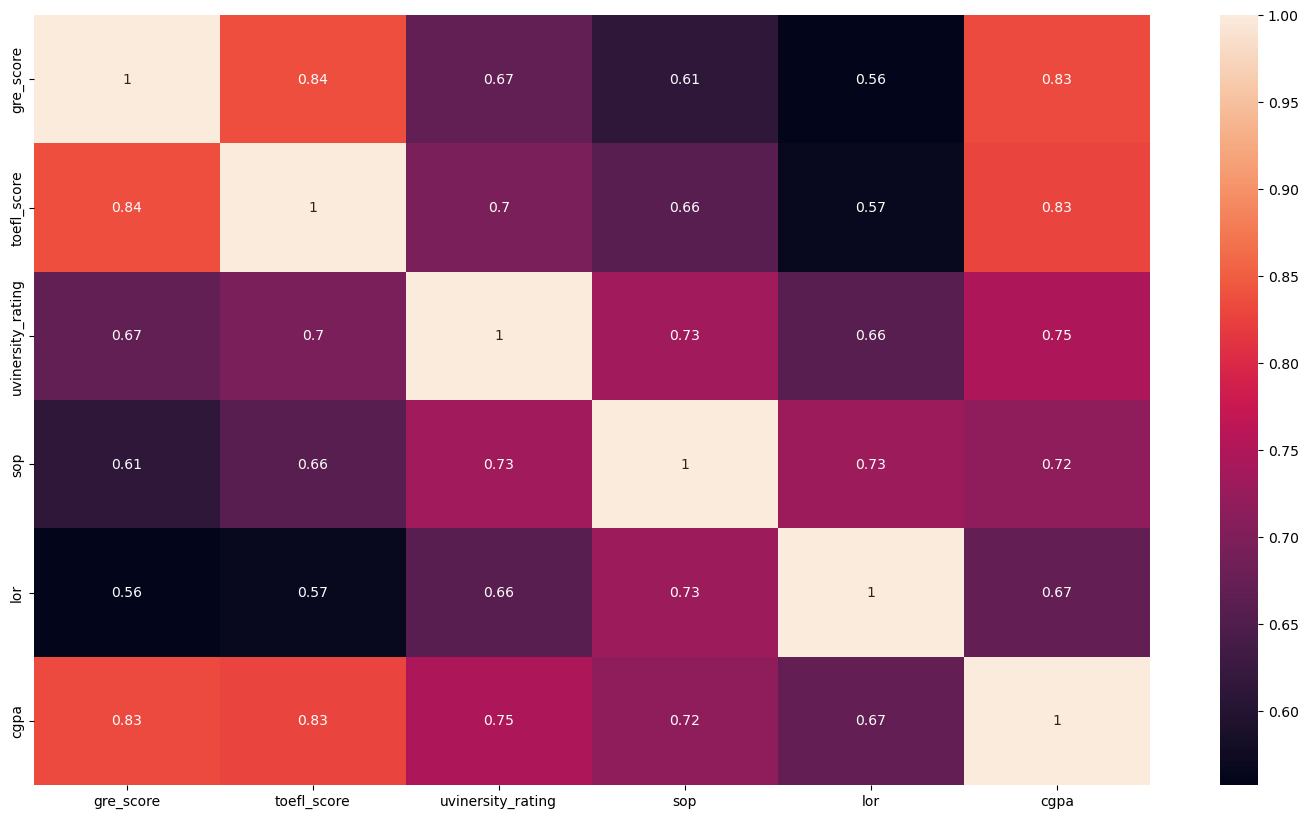

In [9]:
# Verificar correlação entre dados

plt.figure(figsize=(18,10))

sns.heatmap(df[['gre_score', 'toefl_score', 'uvinersity_rating', 'sop', 'lor', 'cgpa']].corr(), annot=True)

**Obs**.

1. À medida que a pontuação do GRE aumenta, a pontuação do TOEFL também aumenta e até a pontuação do CGPA aumenta. Isso significa que os alunos com boas pontuações no GRE também obtêm boas pontuações no TOEFL e têm melhores CGPAs.
2. A pontuação GRE tem uma distribuição com uma média próxima a 320 e a maioria dos alunos pontua entre 310 e 330, o que é indicado pelos picos no gráfico.
3. Alunos com classificação universitária mais alta têm pontuações GRE, TOEFL e CGPA mais altas.
4. Os alunos têm melhor classificação LOR e SOP quando são de universidades com classificação mais alta.
5. Podemos ver uma tendência semelhante para a relação entre GRE Scores, TOEFL Scores, CGPA Scores, LOR Ratings e SOP Ratings. 

Todos eles aumentam juntos, ou seja, como alunos com melhores SOPs também tendem a ter melhores LORs, melhores pontuações GRE, TOEFL e CGPA e são de
universidades com classificação mais alta e têm maior chance de admissão

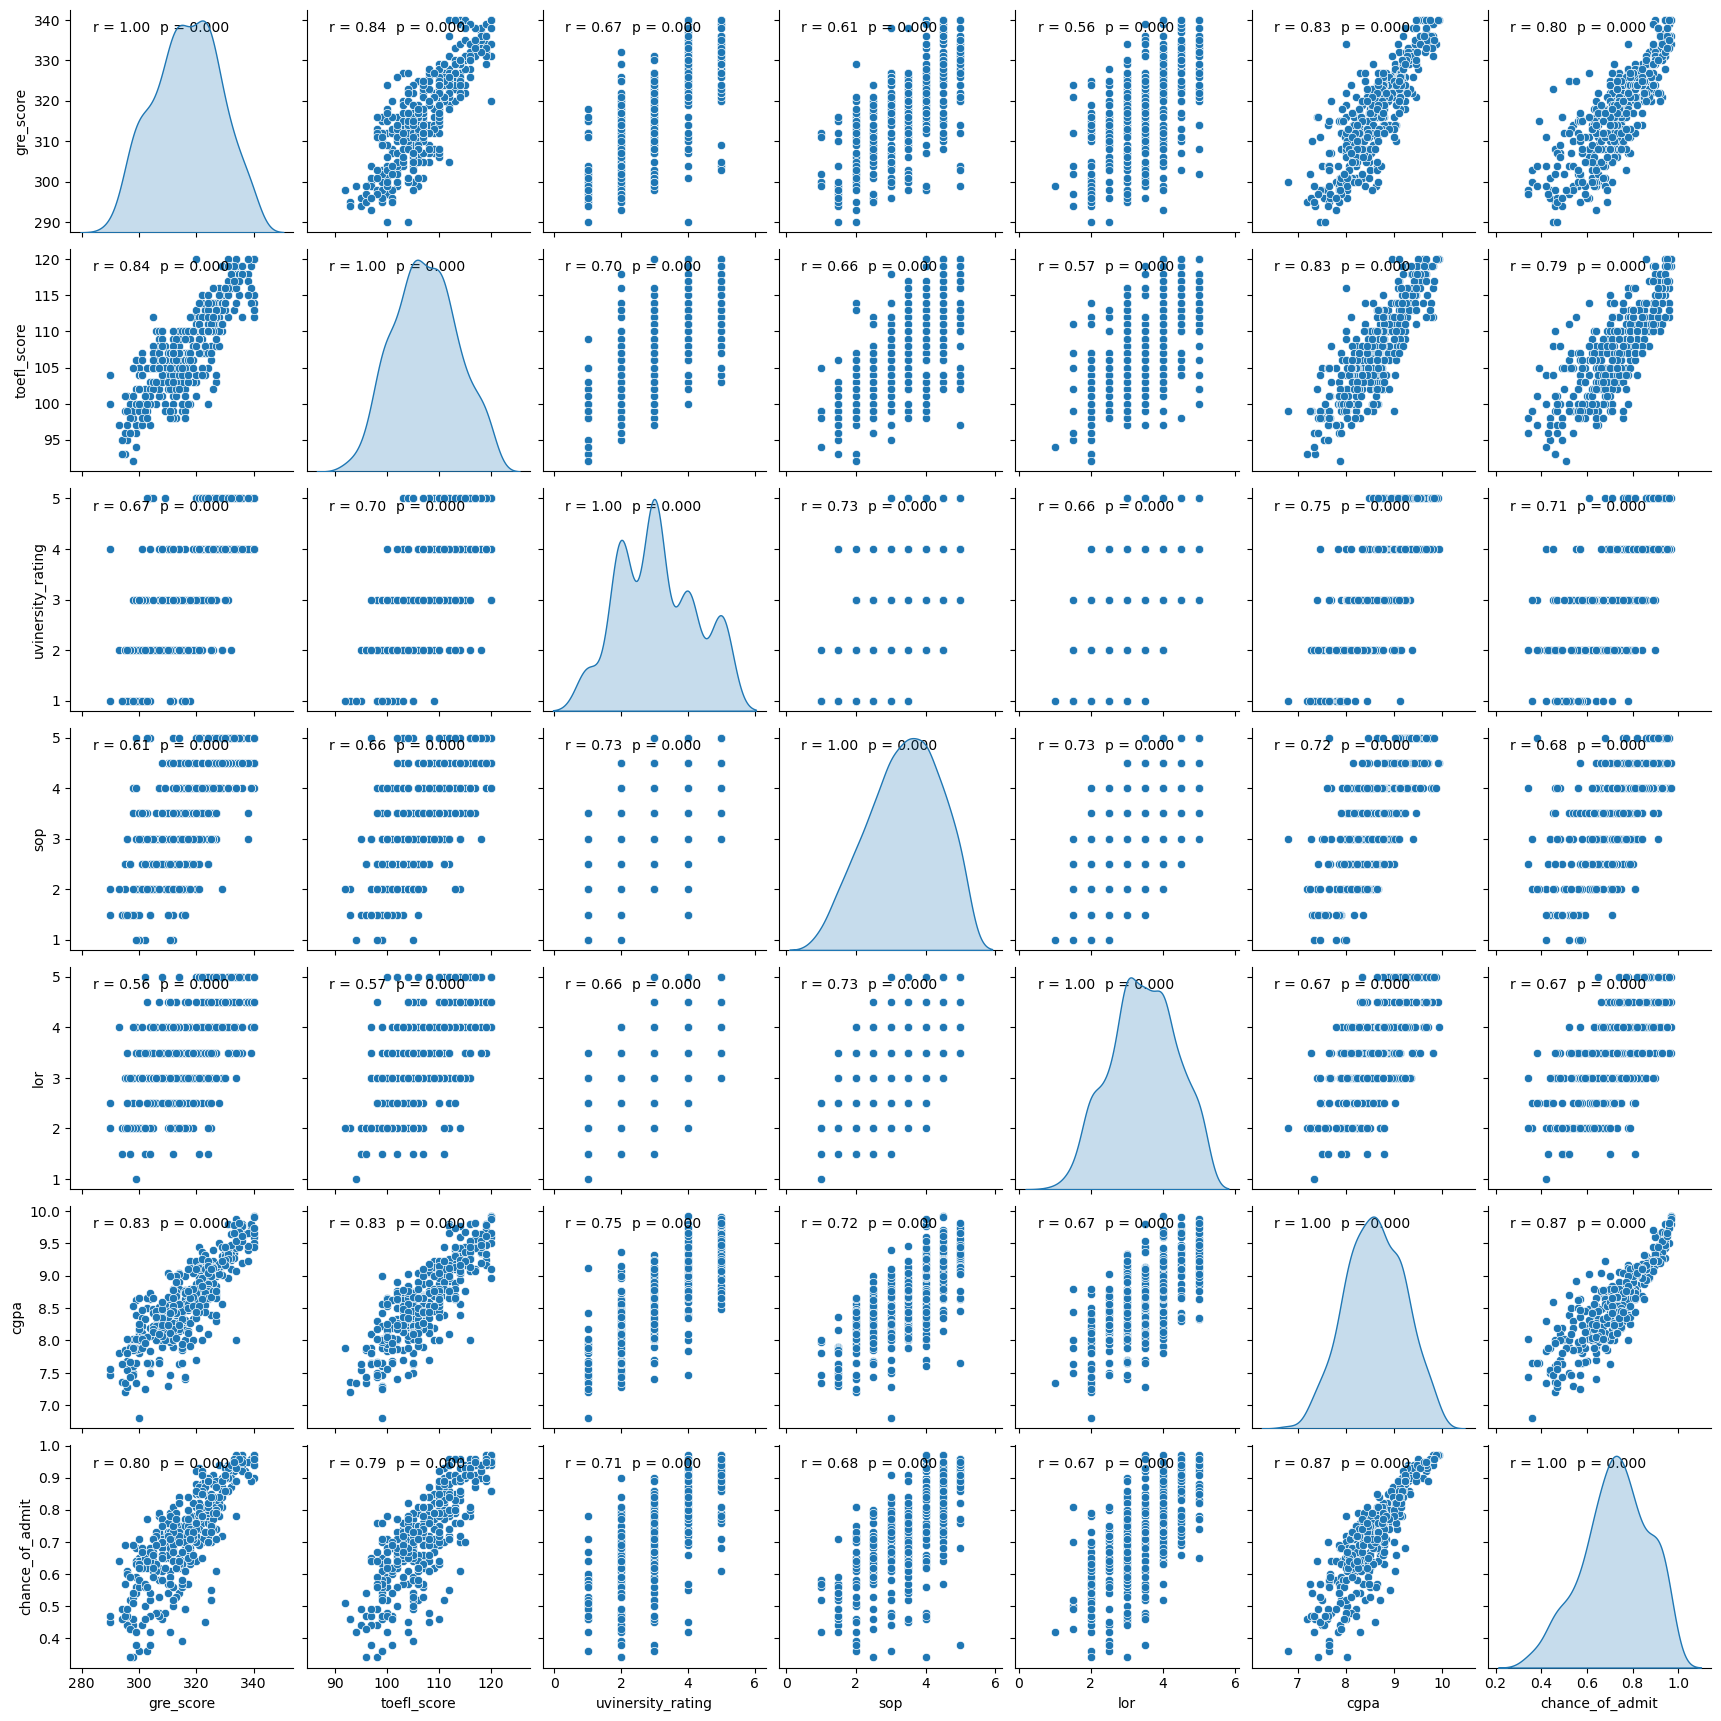

In [10]:
#%% Visualizar o pairplot

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

graph = sns.pairplot(df.drop(columns='research'), diag_kind="kde")
graph.map(corrfunc)
plt.show()

### Modelo_prep_train_test

In [11]:
# Separando as variáveis Y e X

X = df.drop(columns=["chance_of_admit"])
y = df["chance_of_admit"]

In [12]:
# Coletar os nomes das variáveis X

features = list(df.drop(columns=["chance_of_admit"]).columns)

In [13]:
# Criando amostras de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

##### Verificando a amplitude das variáveis para uma possível padronização

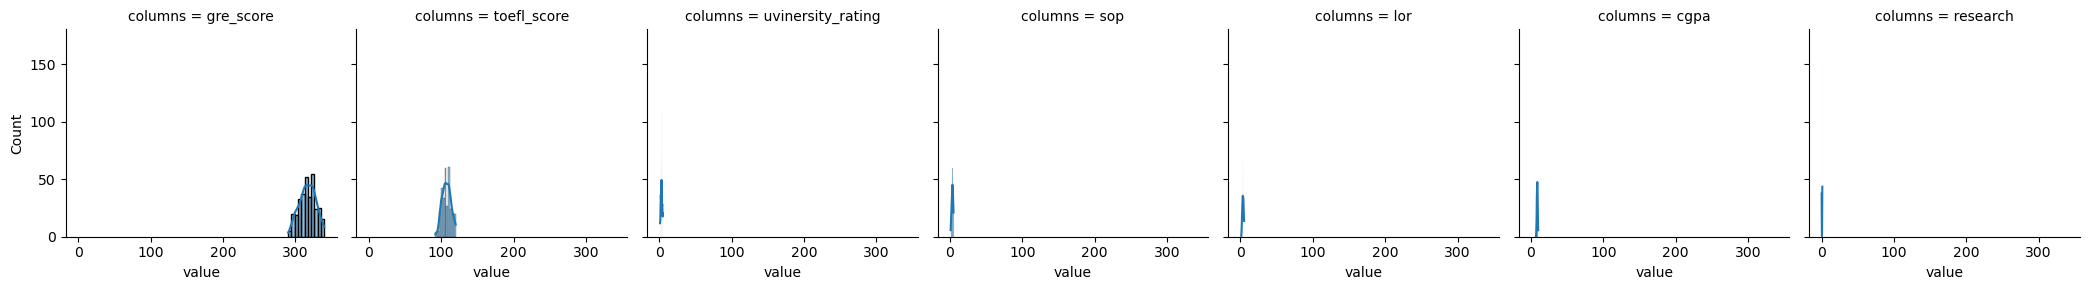

In [14]:
# Verificando a amplitude das variáveis para uma possível padronização

dfm = X_train.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.histplot, 'value', kde=True));

#### Padronizando variáveis com o método z-score

In [15]:
#%% Padronizando variáveis com o método z-score

scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

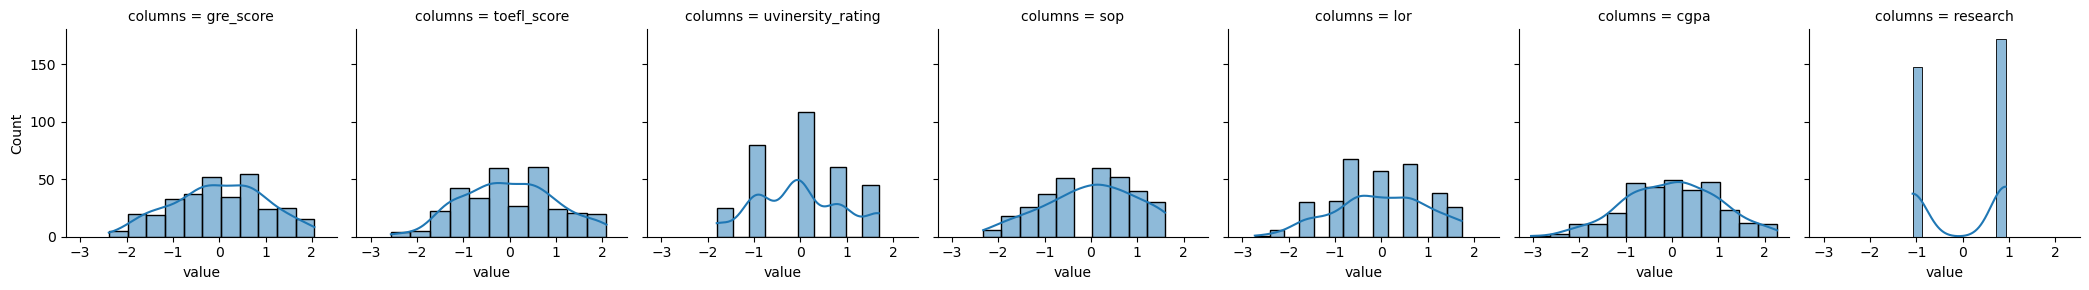

In [16]:
# Verificando a amplitude das variáveis pós padronização

dfm = X_train.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.histplot, 'value', kde=True));

## Bagging

#### GridSearchCV: Comparação, árvore de regressão e o melhor fit

In [46]:
# 1: Para fins de comparação, estima-se uma árvore de regressão através do grid search (para obtenção do melhor fit)
"""
->  estimator,
->  param_grid, -> Dictionary with parameters names ,
->  scoring=None, -> 'r2'
    n_jobs=None,
    refit=True,
    cv=None -> int, cross-validation generator or an iterable
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
->  return_train_score=False,
"""

gs_comp_eu = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                       param_grid= {'max_depth': [2, 3, 4, 5, 6, 7 , 8, 9, 10, None]},
                       # padrão é cv = 5,
                       scoring='r2')

# fit the train set
gs_comp_eu.fit(X=X_train, y=y_train)

# fit data to df
resultados_tree_reg_eu =pd.DataFrame(gs_comp_eu.cv_results_).set_index('rank_test_score').sort_index()


In [47]:
resultados_tree_reg_eu.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,
1,0.002423,0.000874,0.002257,0.002009,4,{'max_depth': 4},0.697077,0.568770,0.692039,0.690004,0.823396,0.694257,0.080567
2,0.003218,0.000922,0.007358,0.010321,3,{'max_depth': 3},0.665209,0.566379,0.698155,0.685505,0.759498,0.674949,0.062739


In [41]:
# 1: Para fins de comparação, estima-se uma árvore de regressão através do grid search (para obtenção do melhor fit)
"""
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
    
"""
gs_comp = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                       param_grid={'max_depth': [2, 3, 4, 5, 6, 7 , 8, 9, 10, None]},
                       cv=5,
                       return_train_score=False,
                       scoring='r2')

gs_comp.fit(X=X_train, y=y_train)

resultados_tree_reg = pd.DataFrame(gs_comp.cv_results_).set_index('rank_test_score').sort_index()

In [42]:
#print(resultados_tree_reg)

In [43]:
resultados_tree_reg.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,
1,0.003429,0.000813,0.001899,0.000416,4,{'max_depth': 4},0.697077,0.568770,0.692039,0.690004,0.823396,0.694257,0.080567
2,0.003150,0.001227,0.002273,0.001243,3,{'max_depth': 3},0.665209,0.566379,0.698155,0.685505,0.759498,0.674949,0.062739


In [53]:
best_depth = resultados_tree_reg.params[1]

#### 2: Estimando um modelo bagging como base para regressão


In [ ]:
#%% 2: Estimando um modelo bagging como base para regressão -> usando o valor de profundidade observado como primeiro no dado anterior

"""
base_estimator=None,
    n_estimators=10,
    *,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
"""

bag_reg = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=4),
        #n_estimators=10, # valor default
        #max_samples=1.0, # valor default
        #bootstrap=True, # valor default # bootstrap = True indica modelo Bagging / False = Pasting 
        #n_jobs=-1, # valor default=None  # utiliza todos os núcleos do computador
        random_state=42) 

In [29]:
bag_reg.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                 random_state=42)

In [30]:
# Predict do modelo bagging da regressão
y_pred_reg = bag_reg.predict(X_test)

n_scores = cross_val_score(bag_reg, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')

R2: 0.745 (0.089)


In [31]:
# score médio do modelo
print('R2: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R2: 0.745 (0.089)


#### Ajustando um modelo bagging através do grid search e comparativos de vários estimadores

In [33]:
# Ajustando um modelo bagging através do grid search e comparativos de vários estimadores

estimator = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                             random_state=42)

gs_bag = GridSearchCV(estimator=estimator,
                        param_grid={
                            'n_estimators': [10, 50, 100, 200],
                            'base_estimator__max_depth':[3,4]
                        },
                        cv=5,
                        return_train_score=False,
                        scoring='r2')

gs_bag.fit(X=X_train, y=y_train)

resultados_bag_reg = pd.DataFrame(gs_bag.cv_results_).set_index('rank_test_score').sort_index()

In [34]:
resultados_bag_reg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,0.292139,0.015088,0.018683,0.006204,4,200,"{'base_estimator__max_depth': 4, 'n_estimators...",0.741087,0.673962,0.771482,0.741117,0.818344,0.749199,0.047051
2,0.155061,0.015380,0.009876,0.001672,4,100,"{'base_estimator__max_depth': 4, 'n_estimators...",0.745323,0.677611,0.771660,0.740578,0.804796,0.747994,0.041958
3,0.317923,0.029953,0.020437,0.001258,3,200,"{'base_estimator__max_depth': 3, 'n_estimators...",0.739688,0.679602,0.766085,0.728147,0.817381,0.746181,0.045312
4,0.161442,0.017722,0.011878,0.003218,3,100,"{'base_estimator__max_depth': 3, 'n_estimators...",0.740388,0.682257,0.763910,0.729298,0.809673,0.745105,0.041820
5,0.080698,0.005528,0.005615,0.000696,4,50,"{'base_estimator__max_depth': 4, 'n_estimators...",0.745934,0.672792,0.767152,0.734945,0.796085,0.743382,0.040996
6,0.073697,0.004810,0.005536,0.000730,3,50,"{'base_estimator__max_depth': 3, 'n_estimators...",0.739278,0.677166,0.758274,0.724391,0.806640,0.741150,0.042333
7,0.018456,0.001397,0.002612,0.000387,4,10,"{'base_estimator__max_depth': 4, 'n_estimators...",0.721554,0.667362,0.758157,0.735776,0.777282,0.732026,0.037513
8,0.025121,0.014756,0.003568,0.001558,3,10,"{'base_estimator__max_depth': 3, 'n_estimators...",0.724483,0.665538,0.746337,0.727515,0.784572,0.729689,0.038565


In [74]:
resultados_bag_reg[['param_n_estimators', 'params', 'mean_test_score']].sort_values(by='mean_test_score', 
                                                                         ascending=False)

,param_n_estimators,params,mean_test_score
rank_test_score,,,
1,200,"{'base_estimator__max_depth': 4, 'n_estimators...",0.749199
2,100,"{'base_estimator__max_depth': 4, 'n_estimators...",0.747994
3,200,"{'base_estimator__max_depth': 3, 'n_estimators...",0.746181
4,100,"{'base_estimator__max_depth': 3, 'n_estimators...",0.745105
5,50,"{'base_estimator__max_depth': 4, 'n_estimators...",0.743382
6,50,"{'base_estimator__max_depth': 3, 'n_estimators...",0.741150
7,10,"{'base_estimator__max_depth': 4, 'n_estimators...",0.732026
8,10,"{'base_estimator__max_depth': 3, 'n_estimators...",0.729689


### Avaliação out-of-bag

In [79]:
# Avaliação out-of-bag

# As observações de treinamento que não são amostradas são "out-of-bag"
# O modelo pode ser avaliado nessas observações sem a necessidade de um conjunto de validação
# Trata-se de uma avaliação automática após o treinamento 
# Seria como se fizesse uma validação em sets diferentes do que foi testado o madelo anterior - serve para validarr tem que ser próximo do valor obtido
#\no caso, obstivemos 0.749 (75%) e obtem-se 0.764 (76%)

# Wiki -> out-of-bag (OOB) error is the mean prediction error on each training sample xi, using only the trees that did not have xi in their bootstrap sample
# Out-of-bag error is used frequently for error estimation within random forests 

# As explained earlier, each decision tree in a random forest is typically trained on ~67% of the training examples. Therefore, each decision tree does not see ~33% of the training examples. The core idea of OOB-evaluation is as follows:
# - To evaluate the random forest on the training set.
# - For each example, only use the decision trees that did not see the example during training.

"""
    base_estimator=None,
    n_estimators=10,
    *,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
->  oob_score=False, -> True -> Whether to use out-of-bag samples to estimate the generalization error
    warm_start=False,
->  n_jobs=None, -> ``-1`` means using all processors
    random_state=None,
    verbose=0,
"""

bag_clf_oob = BaggingRegressor(
    DecisionTreeRegressor(max_depth=4), 
    n_estimators=100, # muito proximo de 200 e gasta-se menos memória e processamento 
    
    bootstrap=True,
    n_jobs= -1, #using all processors
    oob_score=True, # avaliação out-of-bag
    random_state=42) 

bag_clf_oob.fit(X, y)

# Score do modelo
print(bag_clf_oob.oob_score_)

0.7641300751259876


## Random Forests

In [80]:
# O ForestRegressor é mais otimizado para árvores de decisão

rnd_reg = RandomForestRegressor(
    n_estimators=100, 
    max_depth=4, 
    n_jobs=-1, 
    random_state=42)

rnd_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_jobs=-1, random_state=42)

In [81]:
# Predict na base de teste

y_pred_rf = rnd_reg.predict(X_test)
n_scores = cross_val_score(rnd_reg, X, y, scoring='r2', cv=10, n_jobs=-1, error_score='raise')

In [82]:
# Performance final do modelo
## Espera-se um resultado próximo ao bagging

print('R2: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R2: 0.736 (0.131)


### Grid Search com random forest

In [95]:
# Grid Search com random forest

gs_rand = GridSearchCV(estimator=RandomForestRegressor(), # o anterior foi com DecisionTreeRegressor
                          param_grid={
                              'n_estimators': [10, 50, 100, 200], #n de arvores
                              'max_depth':[3,4] 
                          },
                       
                          cv=5,
                          return_train_score=False,
                          scoring='r2')

gs_rand.fit(X=X_train, y=y_train)
resultados_rnd_reg = pd.DataFrame(gs_rand.cv_results_).set_index('rank_test_score').sort_index()

In [96]:
resultados_rnd_reg.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,0.049515,0.002503,0.004238,0.000295,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.738119,0.674586,0.779766,0.754095,0.813917,0.752097,0.046464
2,0.282704,0.036656,0.018197,0.000914,4,200,"{'max_depth': 4, 'n_estimators': 200}",0.743073,0.676958,0.772898,0.741783,0.816554,0.750253,0.045616


In [97]:
#RandonForest
resultados_rnd_reg[['param_n_estimators', 'params', 'mean_test_score']].sort_values(by='mean_test_score', 
                                                                         ascending=False)

,param_n_estimators,params,mean_test_score
rank_test_score,,,
1,50,"{'max_depth': 4, 'n_estimators': 50}",0.752097
2,200,"{'max_depth': 4, 'n_estimators': 200}",0.750253
3,100,"{'max_depth': 4, 'n_estimators': 100}",0.747068
4,200,"{'max_depth': 3, 'n_estimators': 200}",0.746337
5,100,"{'max_depth': 3, 'n_estimators': 100}",0.745409
6,50,"{'max_depth': 3, 'n_estimators': 50}",0.742016
7,10,"{'max_depth': 3, 'n_estimators': 10}",0.741500
8,10,"{'max_depth': 4, 'n_estimators': 10}",0.724840


In [99]:
#%% coletando o melhor modelo

# melhores parâmetros
print(gs_rand.best_params_)     

{'max_depth': 4, 'n_estimators': 50}


In [98]:
#Bag
resultados_bag_reg[['param_n_estimators', 'params', 'mean_test_score']].sort_values(by='mean_test_score', 
                                                                         ascending=False)

,param_n_estimators,params,mean_test_score
rank_test_score,,,
1,200,"{'base_estimator__max_depth': 4, 'n_estimators...",0.749199
2,100,"{'base_estimator__max_depth': 4, 'n_estimators...",0.747994
3,200,"{'base_estimator__max_depth': 3, 'n_estimators...",0.746181
4,100,"{'base_estimator__max_depth': 3, 'n_estimators...",0.745105
5,50,"{'base_estimator__max_depth': 4, 'n_estimators...",0.743382
6,50,"{'base_estimator__max_depth': 3, 'n_estimators...",0.741150
7,10,"{'base_estimator__max_depth': 4, 'n_estimators...",0.732026
8,10,"{'base_estimator__max_depth': 3, 'n_estimators...",0.729689


In [88]:
#%% Importância das variáveis X

importancia = pd.DataFrame({'features':features,
                            'importancia':rnd_reg.feature_importances_})


In [89]:
importancia

,features,importancia
0,gre_score,0.121212
1,toefl_score,0.021726
2,uvinersity_rating,0.005796
3,sop,0.021820
4,lor,0.006527
5,cgpa,0.813796
6,research,0.009124


**Obs.**

- Observa-se que eo GPA (nota do "ENEM") é o que mais importa
- Seguido da nota de linguas para entrar no mestrado
- Depois o TOFEL e o SOP (carta de intenção).

- As notas que menos importam, em ordem crescente:
- Nota da Universidade
- Carta de recomendação
- E se o estudante já desenvolveu pesquisa ou não

#### Coletando os fitted valores do melhor modelo

In [91]:
# Coletando os fitted valores do melhor modelo
## predict() já usa o melhor dos valores obtidos.

y_pred = gs_rand.predict(X=scaler.transform(df.drop(columns='chance_of_admit')))          

### Adicionando os predict no dataframe original

df['y_pred'] = y_pred

/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [104]:
round(df[['chance_of_admit', 'y_pred']], 2)

,chance_of_admit,y_pred
id,,
1,0.92,0.94
2,0.76,0.78
3,0.72,0.65
4,0.80,0.76
5,0.65,0.66
...,...,...
396,0.82,0.80
397,0.84,0.81
398,0.91,0.92


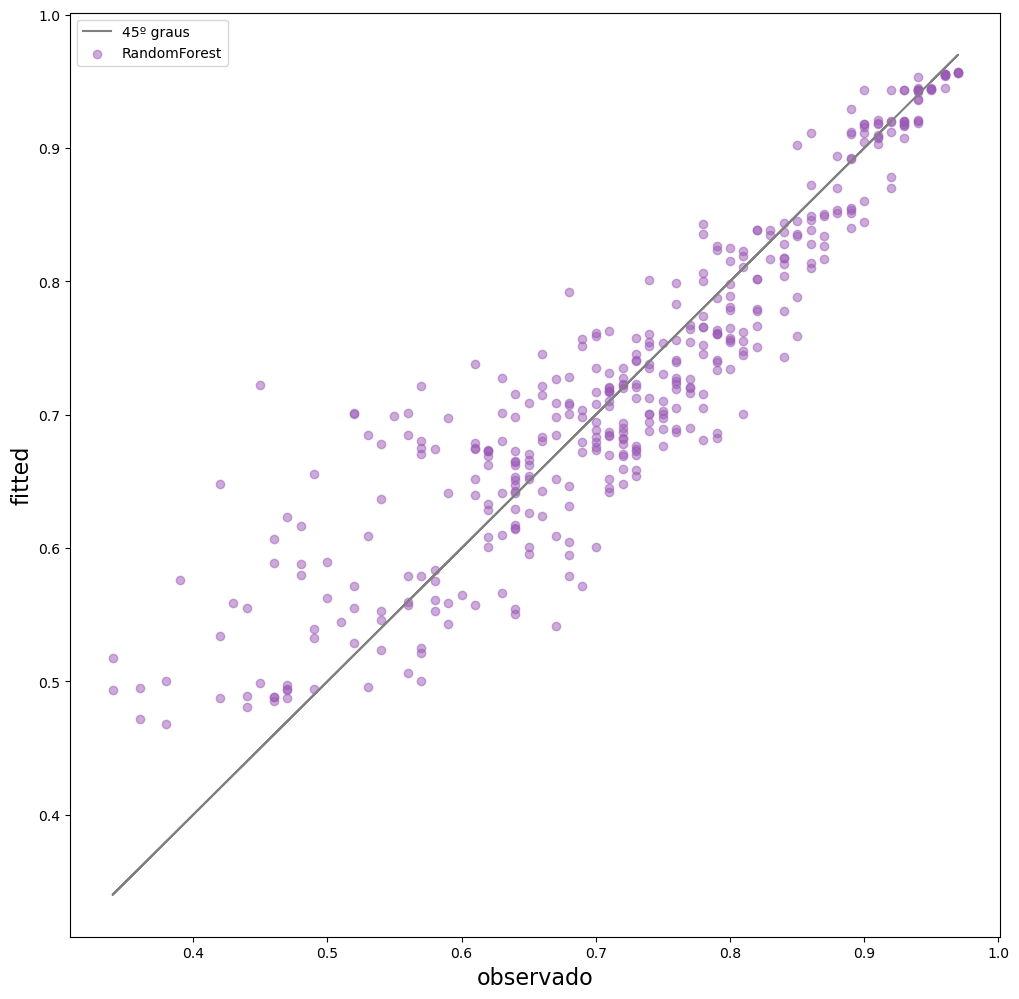

In [111]:
#%% Visualizando dispersão fitted vs observado

# Gráfico didático

plt.figure(figsize=(12, 12))

y = df['chance_of_admit']
yhat = df['y_pred']

plt.plot(y, y, color='gray')

plt.scatter(y , yhat, alpha=0.5, color='#9b59b6')
plt.ylabel("fitted", fontsize=16)
plt.xlabel("observado", fontsize=16)

plt.legend(['45º graus','RandomForest'])

plt.show()


#### comparar agora com o nosso primeiro modelo base

In [112]:
### Vamos comparar agora com o nosso primeiro modelo base ->a árvore de regressão através do grid search (para obtenção do melhor fit) criada lá no início

# Coletando os fitted valores do primeiro modelo

y_pred_comp = gs_comp.predict(X=scaler.transform(df.drop(columns=['chance_of_admit','y_pred'])))    

df['y_pred_comp'] = y_pred_comp

/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


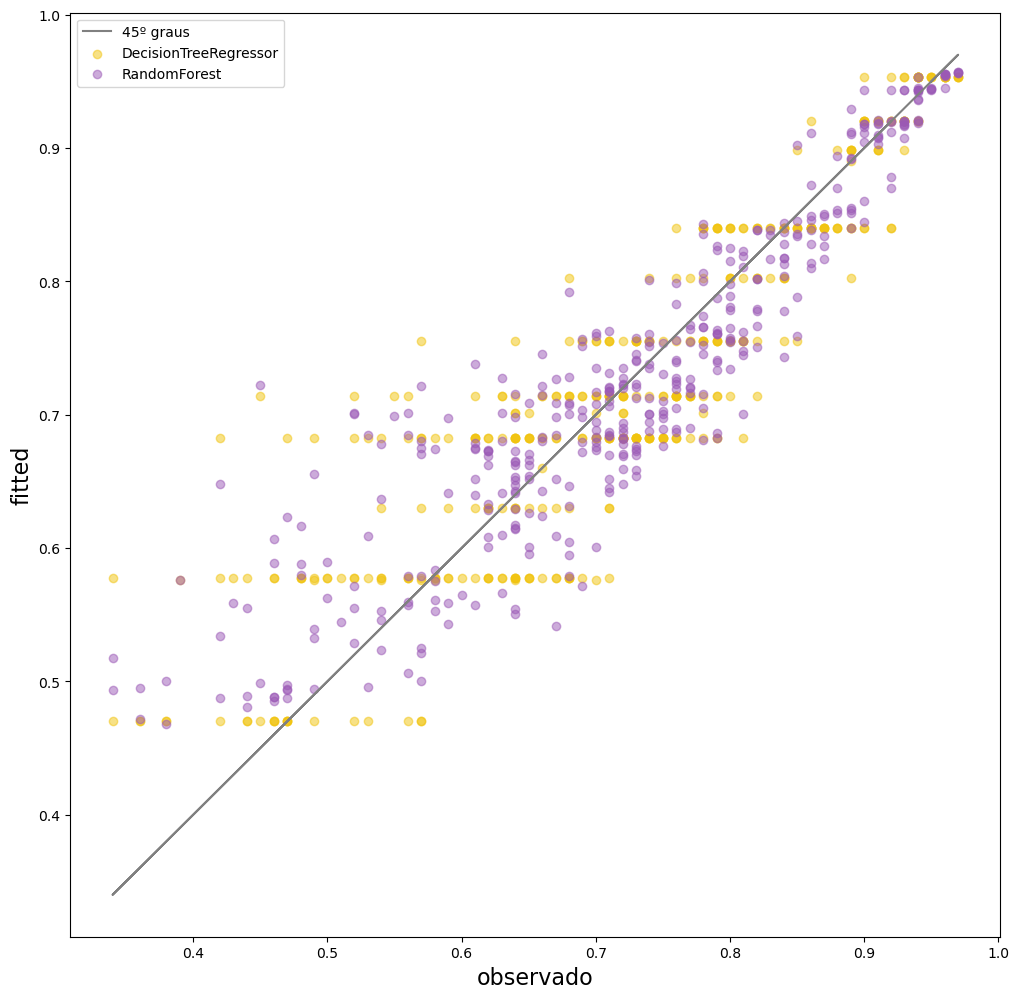

In [113]:
#%% Visualizando disperssão fitted vs observado

# Gráfico didático

plt.figure(figsize=(12, 12))

y = df['chance_of_admit']
yhat = df['y_pred']
y_hat_comp = df['y_pred_comp']

plt.plot(y,y, color='gray')
plt.scatter(y , y_hat_comp, alpha=0.5, color='#f1c40f')
plt.scatter(y , yhat, alpha=0.5, color='#9b59b6')

plt.ylabel("fitted", fontsize=16)
plt.xlabel("observado", fontsize=16)
plt.legend(['45º graus','DecisionTreeRegressor','RandomForest'])
plt.show()

#### verificando os resíduos (diferença entre o real e o predito)

In [114]:
# Coletando e verificando os resíduos

# resíduos da random forest
df['resid_rnd'] = df['chance_of_admit'] - df['y_pred']

# resíduos do comparativo
df['resid_reg'] = df['chance_of_admit'] - df['y_pred_comp']

[]

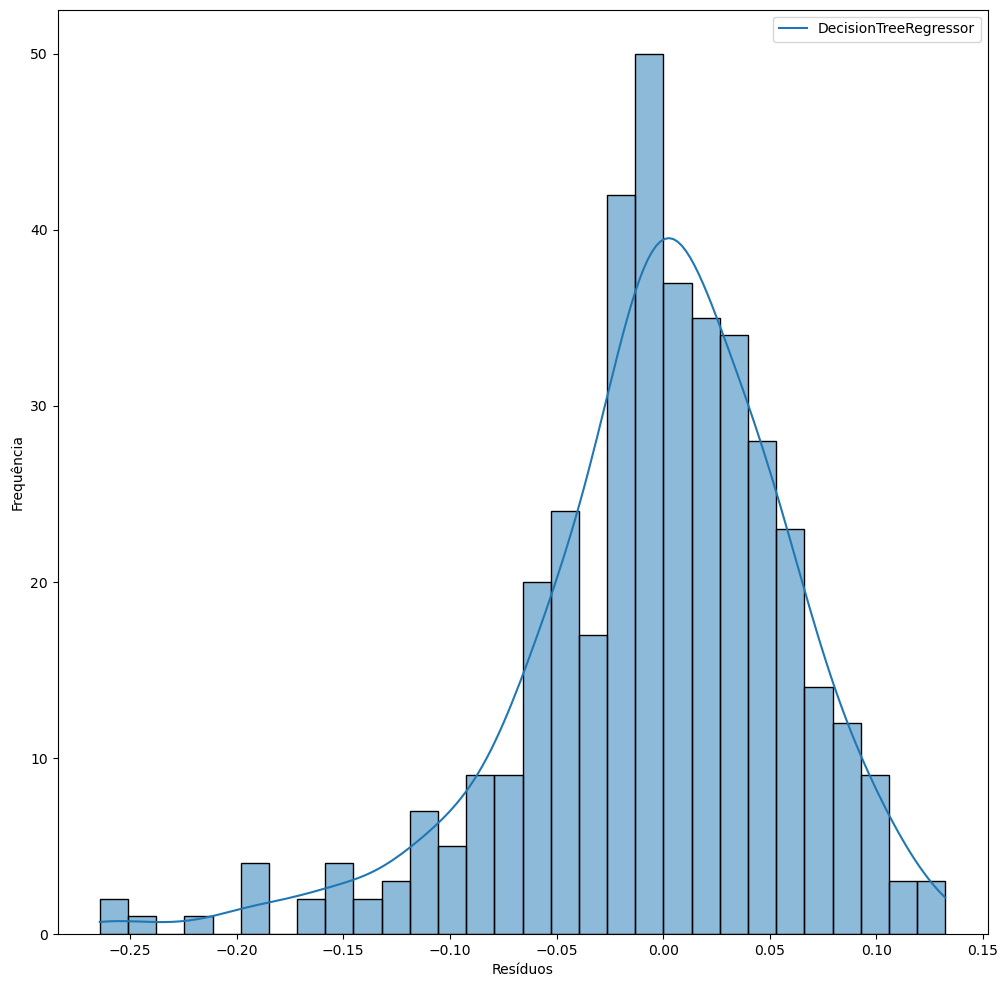

In [118]:
# Visualizando a distribuição dos resíduos no modelo comparativo
## Quanto mais a distribuição se consentrar em torno de zero, melhor
## Queremos evitar caudas longas - tanto para um lado, como para o outro.

plt.figure(figsize=(12, 12))

sns.histplot(data=df['resid_reg'], kde=True, bins=30)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.legend(['DecisionTreeRegressor'])
plt.plot()

[]

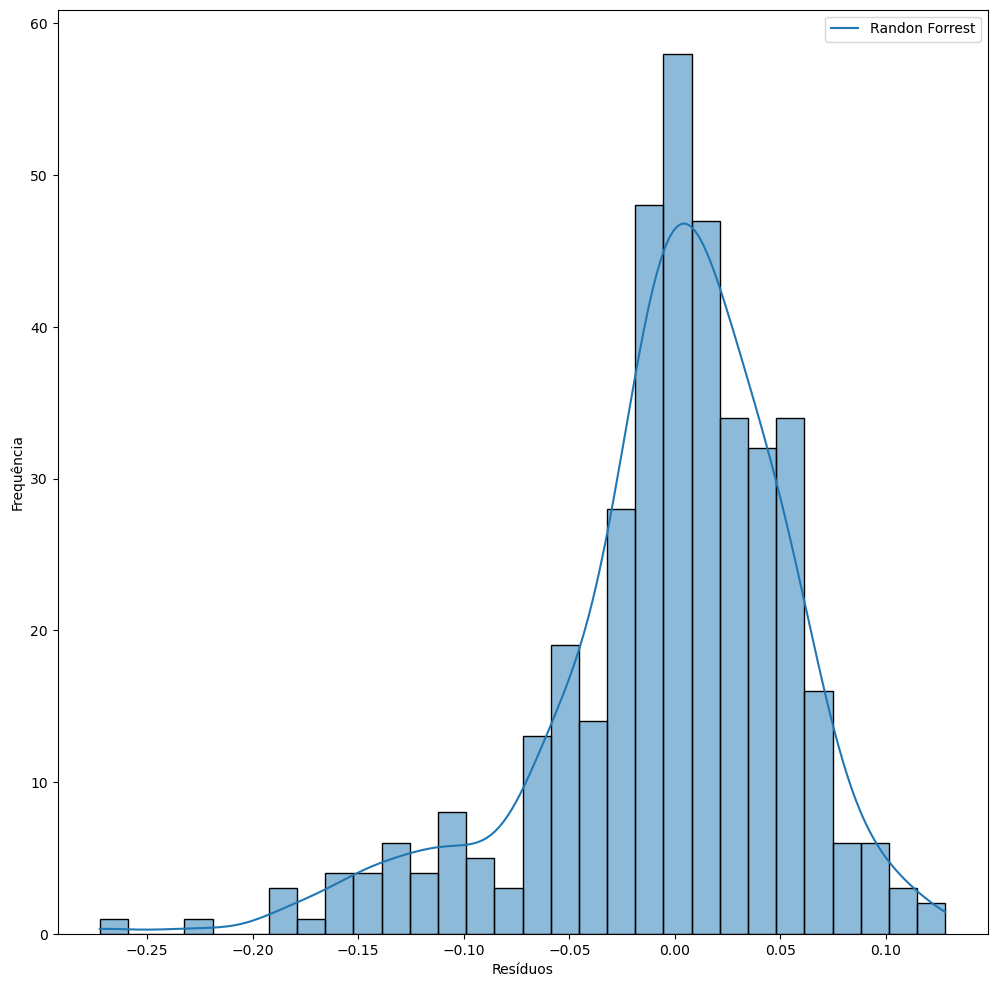

In [119]:
# Visualizando a distribuição dos resíduos no modelo comparativo

plt.figure(figsize=(12, 12))

sns.histplot(data=df['resid_rnd'], kde=True, bins=30)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.legend(['Randon Forrest'])
plt.plot()

**Obs**.

Comparando as duas distribuições observa-se que:
- Já há uma melhora na Randon
- Pois, os dados na ponta da cauda da random são menores
- Há uma concentração maior no centro

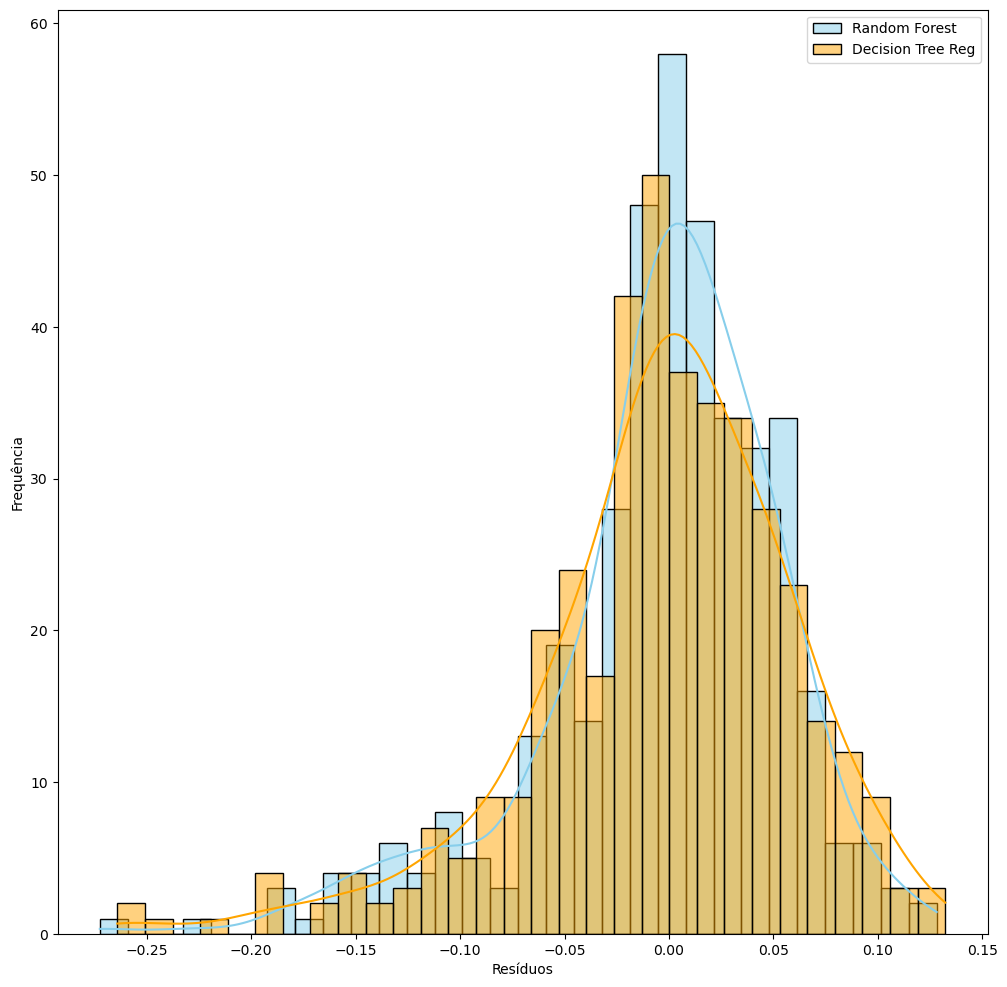

In [120]:
#%% Visualizando os dois no mesmo gráfico para comparativo

import numpy as np

plt.figure(figsize=(12, 12))

sns.histplot(df['resid_rnd'], color="skyblue", label='Random Forest', bins=30, kde=True)
sns.histplot(df['resid_reg'], color="orange", label='Decision Tree Reg', bins=30, kde=True)
plt.legend(loc='upper right')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()


### Pipeline com todas as instruções para gerar o modelo final

In [121]:
# gerado um pipeline com todas as instruções para gerar o modelo final
## primeiro: será feita a padronização dos dados
## segundo: será feito o grid de procura dos melhores parâmetros para o modelo

pipe = make_pipeline(scaler, gs_rand)

In [125]:
# Realizando o predict utilizando o pipeline criado
## duas observações

predict = pd.DataFrame({'gre_score':[337,300], 
                        'toefl_score':[118,100], 
                        'uvinersity_rating':[5,4], 
                        'sop':[4.5,4.6], 
                        'lor':[4.5,4.9], 
                        'cgpa':[9.65,8.5],
                        'research':[1,0]})

print(f"Resultado: {pipe.predict(X=predict)}")


Resultado: [0.94423911 0.6785257 ]


/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Regressores de Votação

**Def**.

Um regressor de votação é um meta-estimador de conjunto que se ajusta a vários regressores de base, 
cada um em todo o conjunto de dados. Em seguida, calcula a média das previsões individuais para formar uma previsão final.

[documentation1](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor)
[documentation2](https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor)

>The idea behind the VotingRegressor is to combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

_________


> from sklearn.ensemble import **VotingClassifier** 

> If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace *voting="hard" with voting="soft"* and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91% accuracy! 

- Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow (p. 186). O'Reilly Media. Kindle Edition. 

- voting = 'hard' 


In [132]:
from sklearn.ensemble import VotingClassifier

In [126]:
## Usando os parametros observados anteriormente na regressão de arvore e random forest

lin_reg_vot = LinearRegression()
tree_reg_vot = DecisionTreeRegressor(max_depth=4, random_state=42)
rnd_reg_vot = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=42)

In [134]:
# Parametrizando o modelo
## (estimators, *, weights=None, n_jobs=None, verbose=False)
## -> estimators -> list of (str, estimator) tuples

voting_ref = VotingRegressor(estimators=[('lr', lin_reg_vot), ('tree', tree_reg_vot), ('rf', rnd_reg_vot)])

voting_ref.fit(X_train, y_train)


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('tree',
                             DecisionTreeRegressor(max_depth=4,
                                                   random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_depth=4,
                                                   random_state=42))])

In [128]:
# Fazendo o predict e identificando o r² de cada modelo:

for clf in (lin_reg_vot, tree_reg_vot, rnd_reg_vot, voting_ref):
    clf.fit(X_train, y_train)
    y_pred_vot = clf.predict(X_test)
    
    n_scores = cross_val_score(clf, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
    
    # report performance
    print(f'{clf.__class__.__name__} R2: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

LinearRegression R2: 0.771 (0.061)
DecisionTreeRegressor R2: 0.705 (0.077)
RandomForestRegressor R2: 0.747 (0.075)
VotingRegressor R2: 0.762 (0.070)


### Boosting

> Boosting (originally called hypothesis boosting ) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are *AdaBoost* (short for Adaptive Boosting) and *Gradient Boosting*.

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow (pp. 193-194). O'Reilly Media. Kindle Edition. 

#### AdaBoost

> One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost. 

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn and TensorFlow (p. 194). O'Reilly Media. Kindle Edition. 

##### Teorico -> LR (learning) rate MSE (minimum square error)

In [135]:
# Teorico

## Função de perda para o MSE
## valores para comparação

y_ref = np.ones((100,1)) # um array com 100 obs de valor 1
y_hat = np.linspace(0, 2, 100) # um array com 100 obs de valor que vão de 0 a 2

In [138]:
# Verificando os shapes

print("y: ", y_ref.shape)
print("y_hat: ", y_hat.shape)

y:  (100, 1)
y_hat:  (100,)


In [139]:
#% Alterando o shape do array para ficar similar

y_hat = y_hat.reshape((-1, 1)) # colocando mais uma coluna para ficar igual. -1 mantem o que tem, 1 acrescenta 1

print("y_hat: ", y_hat.shape)


y_hat:  (100, 1)


In [ ]:
#%% Valor observado para referência

print(y_ref)

#%% Valores preditos indo de 0 a 2 (o valor 1 estará compreendido no array, ou muito proximo de 1)

print(y_hat)


In [ ]:
#%% Criando vetor do erro ao quadrado

mse_array = (y_ref - y_hat)**2


In [142]:
print(mse_array)

[[1.00000000e+00]
 [9.60004081e-01]
 [9.20824406e-01]
 [8.82460973e-01]
 [8.44913784e-01]
 [8.08182838e-01]
 [7.72268136e-01]
 [7.37169677e-01]
 [7.02887460e-01]
 [6.69421488e-01]
 [6.36771758e-01]
 [6.04938272e-01]
 [5.73921028e-01]
 [5.43720029e-01]
 [5.14335272e-01]
 [4.85766758e-01]
 [4.58014488e-01]
 [4.31078461e-01]
 [4.04958678e-01]
 [3.79655137e-01]
 [3.55167840e-01]
 [3.31496786e-01]
 [3.08641975e-01]
 [2.86603408e-01]
 [2.65381084e-01]
 [2.44975003e-01]
 [2.25385165e-01]
 [2.06611570e-01]
 [1.88654219e-01]
 [1.71513111e-01]
 [1.55188246e-01]
 [1.39679625e-01]
 [1.24987246e-01]
 [1.11111111e-01]
 [9.80512193e-02]
 [8.58075707e-02]
 [7.43801653e-02]
 [6.37690032e-02]
 [5.39740843e-02]
 [4.49954086e-02]
 [3.68329762e-02]
 [2.94867871e-02]
 [2.29568411e-02]
 [1.72431385e-02]
 [1.23456790e-02]
 [8.26446281e-03]
 [4.99948985e-03]
 [2.55076013e-03]
 [9.18273646e-04]
 [1.02030405e-04]
 [1.02030405e-04]
 [9.18273646e-04]
 [2.55076013e-03]
 [4.99948985e-03]
 [8.26446281e-03]
 [1.234567

In [143]:
#%% Verificando a MSE (Mean Squared Error)

print(np.mean(mse_array))

0.34006734006734013


In [144]:
#%% Obtendo o mesmo resultado utilizando a biblioteca so scikit-learn

print(mean_squared_error(y_ref, y_hat))


0.34006734006734013


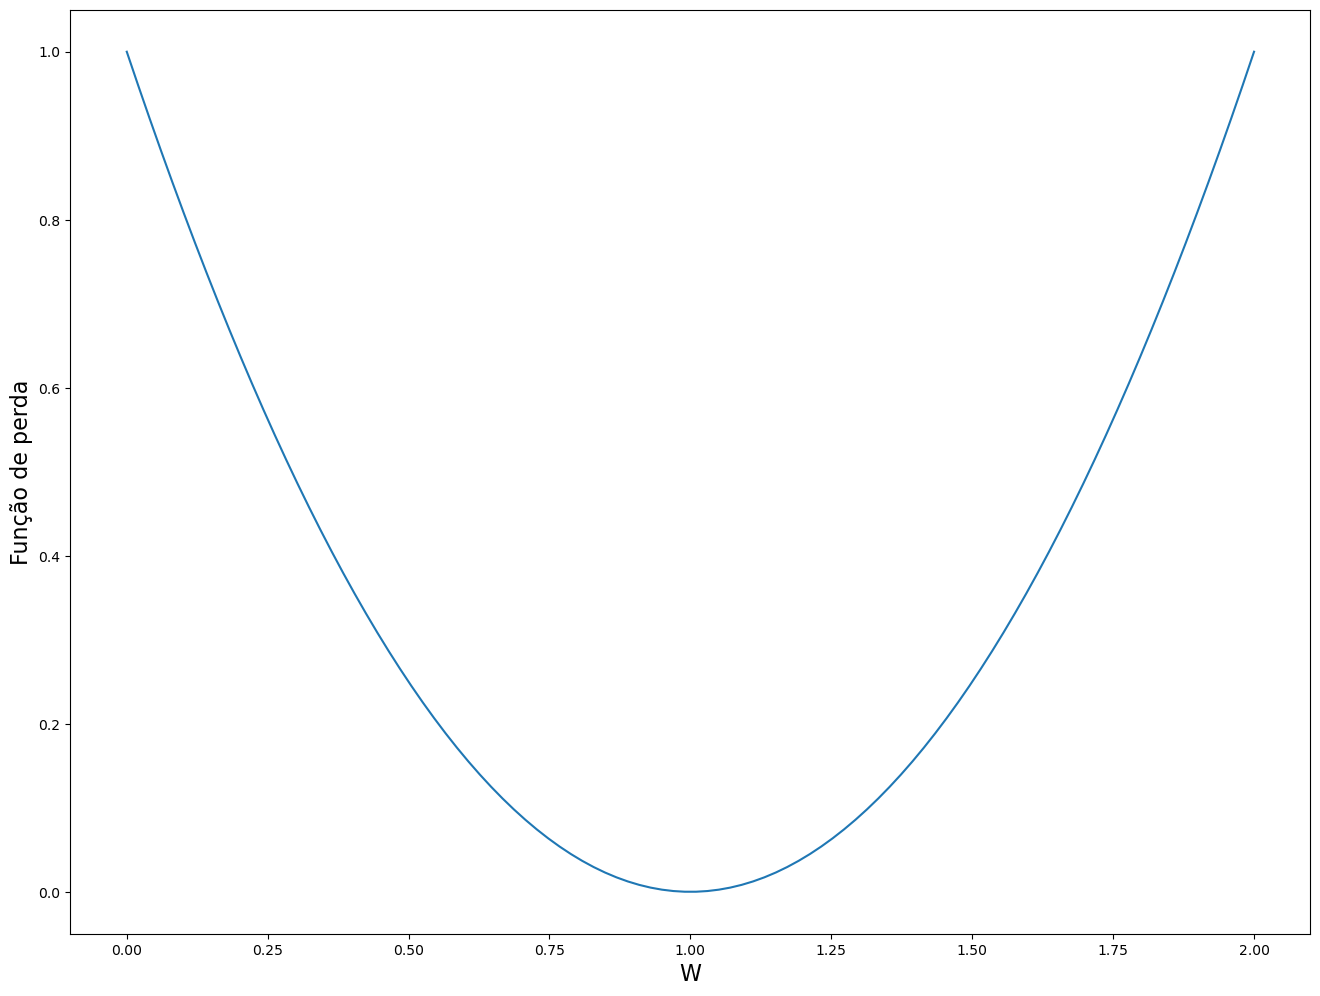

In [145]:
#%% Visualizando o gráfico da função de perda para entender a taxa de aprendizado

plt.figure(figsize=(16, 12))

plt.plot(y_hat, mse_array)
plt.ylabel("Função de perda", fontsize=16)
plt.xlabel("W", fontsize=16)
plt.show()

#### Desenhando modelo de AdaBoost

In [147]:
# Instanciar o modelo de Adaboost com base em uma arvore de decisão de regressão -> com os mesmos paramentos observados como ideiais anteriormente.
##\ ou seja, max_depth=4 e n_estimators = 200 (ou 100)
## mais um LR de 0.1

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4, 
                          #random_state=42
                          ),
    n_estimators=200,
    learning_rate=0.1,
    #random_state=42
    )

In [148]:
# fiting
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  learning_rate=0.1, n_estimators=200)

In [149]:
# Predict na base de teste

y_pred_ada = ada_reg.predict(X_test)
n_scores = cross_val_score(ada_reg, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')

print('R2: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


R2: 0.726 (0.072)


#### Teorico - Lista com cada iteração

In [150]:
#%% Lista com cada iteração -> Qual o erro em cada interação

In [ ]:
#%% Lista com cada iteração

estimators = np.arange(1,201)

#%% Lista que vai receber cada resultado das iterações

scores_train = np.zeros(200, dtype=np.float64)

scores_test = np.zeros(200, dtype=np.float64)



In [154]:
#%% Coletando o MSE de cada iteração nos dados de treino

for i, y_pred in enumerate(ada_reg.staged_predict(X_train)):
    
    mse = mean_squared_error(y_train, y_pred)
    
    scores_train[i] = mse
    
print(scores_train)

[0.00430892 0.00457329 0.00362845 0.00362845 0.00327473 0.0034527
 0.00330864 0.00329386 0.00310979 0.00304306 0.00301062 0.00297997
 0.00299881 0.00297607 0.00300572 0.0029051  0.00293323 0.0028929
 0.00295116 0.00288421 0.00291663 0.00290684 0.00290296 0.00294462
 0.0028805  0.00288384 0.00289791 0.00288642 0.00287458 0.00290448
 0.00290741 0.00288954 0.00287573 0.00285979 0.00283949 0.00283778
 0.00282492 0.00279863 0.0028491  0.0028139  0.00282759 0.00279718
 0.00273454 0.00269142 0.00269548 0.00268661 0.00267455 0.00263087
 0.0026586  0.00263044 0.00263414 0.00263806 0.00262358 0.00262511
 0.00262481 0.00262212 0.00262341 0.00263518 0.00262182 0.00261965
 0.00260682 0.00262375 0.00261385 0.00261732 0.00260377 0.0026127
 0.00261487 0.00260575 0.00259013 0.00258247 0.0025648  0.00257684
 0.00256955 0.00258241 0.00257873 0.00255816 0.00256604 0.00253894
 0.00254503 0.00252925 0.00253626 0.00253395 0.00253257 0.00254094
 0.00253403 0.00251589 0.00253209 0.00252546 0.00253203 0.0025402

In [153]:
#%% Coletando o MSE de cada iteração nos dados de teste

for i, y_pred in enumerate(ada_reg.staged_predict(X_test)):
    
    mse = mean_squared_error(y_test, y_pred)
    
    scores_test[i] = mse
    
print(scores_train)

[0.00430892 0.00457329 0.00362845 0.00362845 0.00327473 0.0034527
 0.00330864 0.00329386 0.00310979 0.00304306 0.00301062 0.00297997
 0.00299881 0.00297607 0.00300572 0.0029051  0.00293323 0.0028929
 0.00295116 0.00288421 0.00291663 0.00290684 0.00290296 0.00294462
 0.0028805  0.00288384 0.00289791 0.00288642 0.00287458 0.00290448
 0.00290741 0.00288954 0.00287573 0.00285979 0.00283949 0.00283778
 0.00282492 0.00279863 0.0028491  0.0028139  0.00282759 0.00279718
 0.00273454 0.00269142 0.00269548 0.00268661 0.00267455 0.00263087
 0.0026586  0.00263044 0.00263414 0.00263806 0.00262358 0.00262511
 0.00262481 0.00262212 0.00262341 0.00263518 0.00262182 0.00261965
 0.00260682 0.00262375 0.00261385 0.00261732 0.00260377 0.0026127
 0.00261487 0.00260575 0.00259013 0.00258247 0.0025648  0.00257684
 0.00256955 0.00258241 0.00257873 0.00255816 0.00256604 0.00253894
 0.00254503 0.00252925 0.00253626 0.00253395 0.00253257 0.00254094
 0.00253403 0.00251589 0.00253209 0.00252546 0.00253203 0.0025402

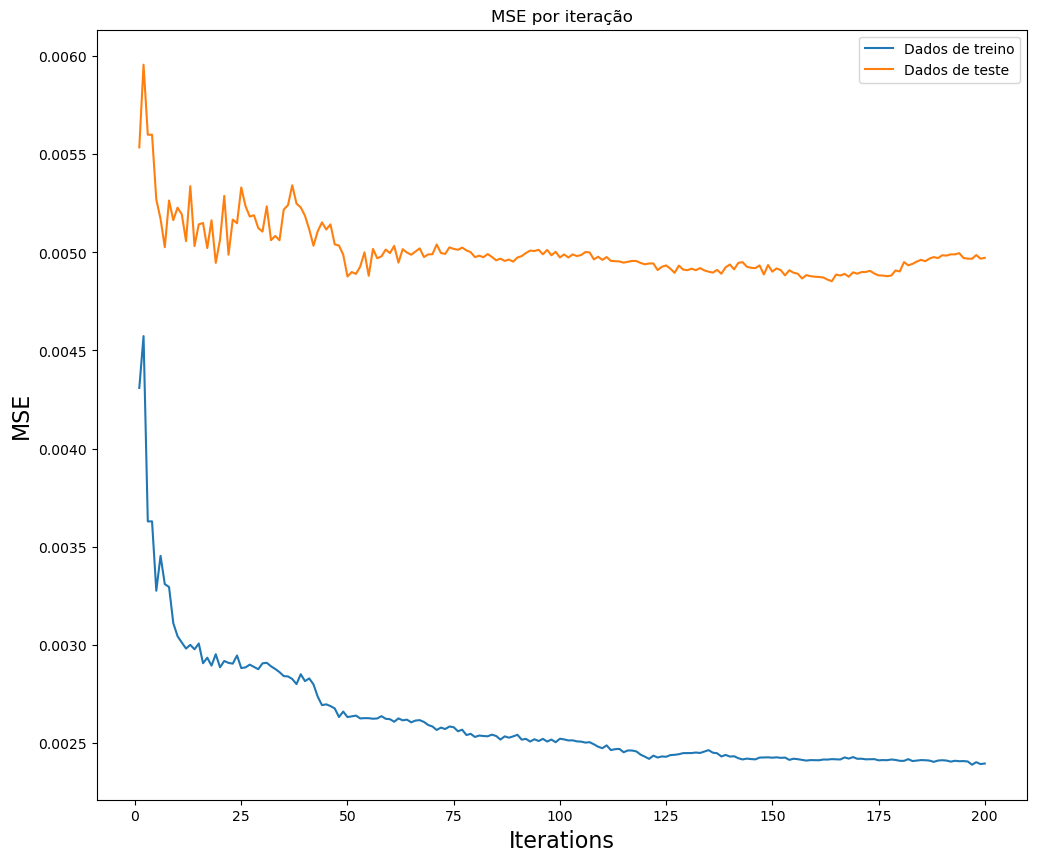

In [155]:
#%% Visualizando o MSE ao longo de cada iteração

plt.figure(figsize=(12, 10))
plt.title("MSE por iteração")
plt.plot(estimators,scores_train, label='Dados de treino')
plt.plot(estimators,scores_test, label='Dados de teste')
plt.legend(loc="upper right")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.show()

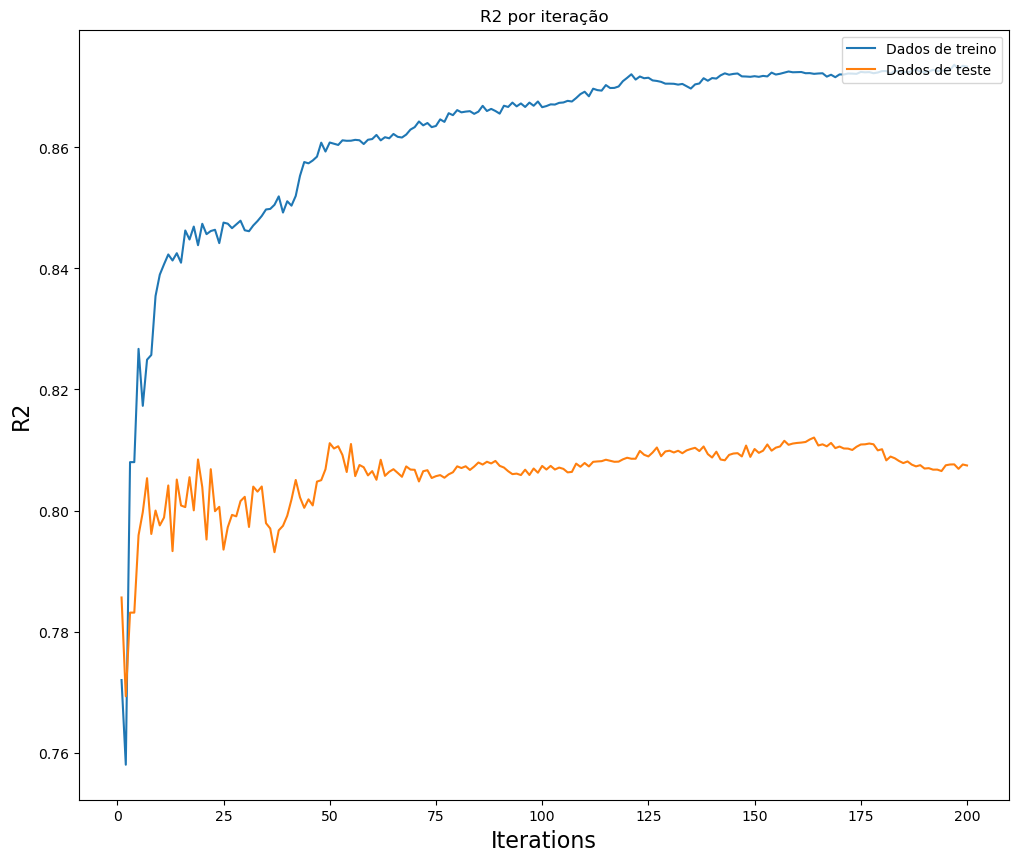

In [156]:
#%% Coletando o r² de cada iteração nas bases de treino e teste

from sklearn.metrics import r2_score

# r² nos dados de treino
for i, y_pred in enumerate(ada_reg.staged_predict(X_train)):
    
    r2 = r2_score(y_train, y_pred)
    
    scores_train[i] = r2

# r² nos dados de teste
for i, y_pred in enumerate(ada_reg.staged_predict(X_test)):
    
    r2 = r2_score(y_test, y_pred)
    
    scores_test[i] = r2
    
#%% Visualizando o R2 ao longo de cada iteração

plt.figure(figsize=(12, 10))
plt.title("R2 por iteração")
plt.plot(estimators,scores_train, label='Dados de treino')
plt.plot(estimators,scores_test, label='Dados de teste')
plt.legend(loc="upper right")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("R2", fontsize=16)
plt.show()


#### Pratico - Lista com cada iteração

In [157]:
#%% Coletando o predict do adaptative boosting no dataframe original

y_pred_ada_reg = ada_reg.predict(scaler.transform(X))

df['y_pred_ada_reg'] = y_pred_ada_reg


/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [158]:
df['y_pred_ada_reg']

id
1      0.930714
2      0.783684
3      0.629231
4      0.762979
5      0.630682
         ...   
396    0.793415
397    0.808000
398    0.915714
399    0.721667
400    0.929545
Name: y_pred_ada_reg, Length: 400, dtype: float64

In [159]:
df.head()

,gre_score,toefl_score,uvinersity_rating,sop,lor,cgpa,research,chance_of_admit,y_pred,y_pred_comp,resid_rnd,resid_reg,y_pred_ada_reg
id,,,,,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92,0.943605,0.953158,-0.023605,-0.033158,0.930714
2,324,107,4,4.0,4.5,8.87,1,0.76,0.782681,0.840256,-0.022681,-0.080256,0.783684
3,316,104,3,3.0,3.5,8.00,1,0.72,0.647784,0.701667,0.072216,0.018333,0.629231
4,322,110,3,3.5,2.5,8.67,1,0.80,0.756129,0.755128,0.043871,0.044872,0.762979
5,314,103,2,2.0,3.0,8.21,0,0.65,0.662462,0.682203,-0.012462,-0.032203,0.630682


In [161]:
round(df[['chance_of_admit', 'y_pred', 'y_pred_comp', 'y_pred_ada_reg']],2)

,chance_of_admit,y_pred,y_pred_comp,y_pred_ada_reg
id,,,,
1,0.92,0.94,0.95,0.93
2,0.76,0.78,0.84,0.78
3,0.72,0.65,0.70,0.63
4,0.80,0.76,0.76,0.76
5,0.65,0.66,0.68,0.63
...,...,...,...,...
396,0.82,0.80,0.80,0.79
397,0.84,0.81,0.80,0.81
398,0.91,0.92,0.92,0.92


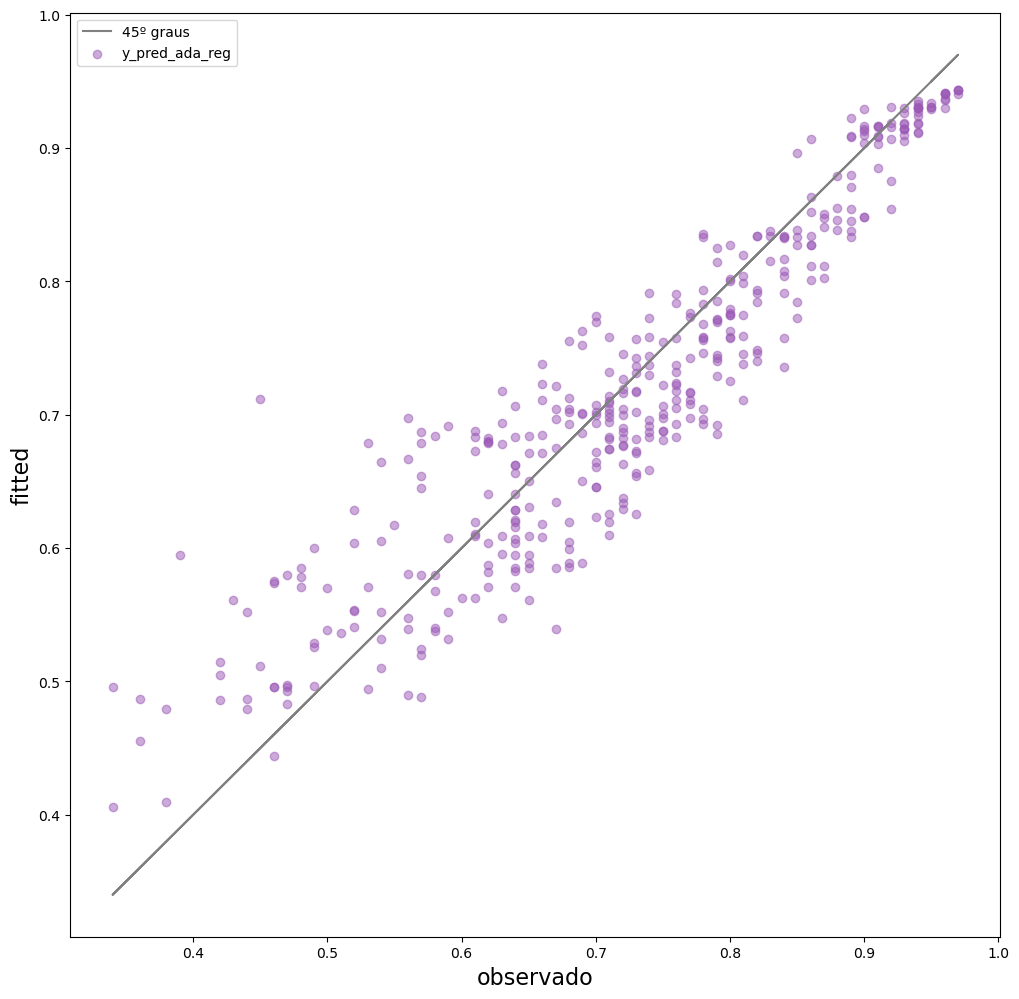

In [170]:
# Gráfico didático

plt.figure(figsize=(12, 12))

y = df['chance_of_admit']
yhat = df['y_pred_ada_reg']


plt.plot(y,y, color='gray')
plt.scatter(y , yhat, alpha=0.5, color='#9b59b6')

plt.ylabel("fitted", fontsize=16)
plt.xlabel("observado", fontsize=16)
plt.legend(['45º graus','y_pred_ada_reg','RandomForest'])
plt.show()

### Gradiente Boosting

In [165]:
#%% Gradiente Boosting

gbc = GradientBoostingRegressor(max_depth=4, 
                                n_estimators=200, # valor default -> 100
                                learning_rate = 0.1, 
                                random_state=42)
gbc.fit(X_train, y_train)

n_scores = cross_val_score(gbc, X, y, scoring='r2', cv=10, n_jobs=-1, error_score='raise')

print('R2: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

R2: 0.673 (0.119)


In [166]:
n_scores

array([0.67984453, 0.46691003, 0.71430468, 0.55274466, 0.63137265,
       0.86103967, 0.69290512, 0.78379837, 0.54712218, 0.80214009])

In [167]:
#%% Coletando o predict do gradient boosting no dataframe original

y_pred_gbc = gbc.predict(scaler.transform(X))

df['y_pred_gbc'] = y_pred_gbc

/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


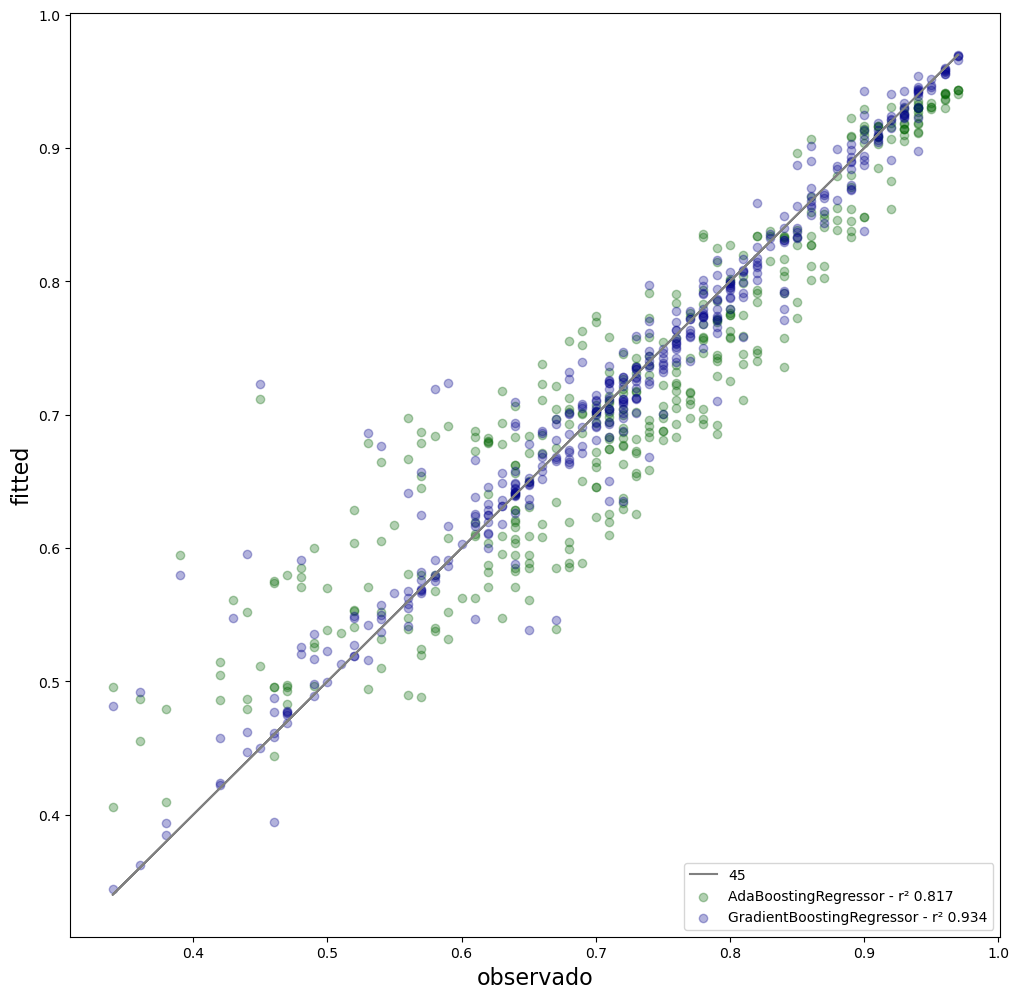

In [173]:
# Gráfico didático

plt.figure(figsize=(12, 12))

y = df['chance_of_admit']

y_hat_gbc = df['y_pred_gbc']
y_pred_ada_reg = df['y_pred_ada_reg']

plt.plot(y,y, color='gray', label='45')
plt.scatter(y , y_pred_ada_reg, alpha=0.3, color='darkgreen', label=f'AdaBoostingRegressor - r² {round(r2_score(y_pred_ada_reg, y),3)}')
plt.scatter(y , y_hat_gbc, alpha=0.3, color='darkblue', label=f'GradientBoostingRegressor - r² {round(r2_score(y_hat_gbc, y),3)}')

plt.ylabel("fitted", fontsize=16)
plt.xlabel("observado", fontsize=16)
plt.legend(loc="lower right")
plt.show()


In [175]:
#%% Coletando os resíduos do gbc

df['resid_gbc'] =  df['chance_of_admit'] - df['y_pred_gbc']


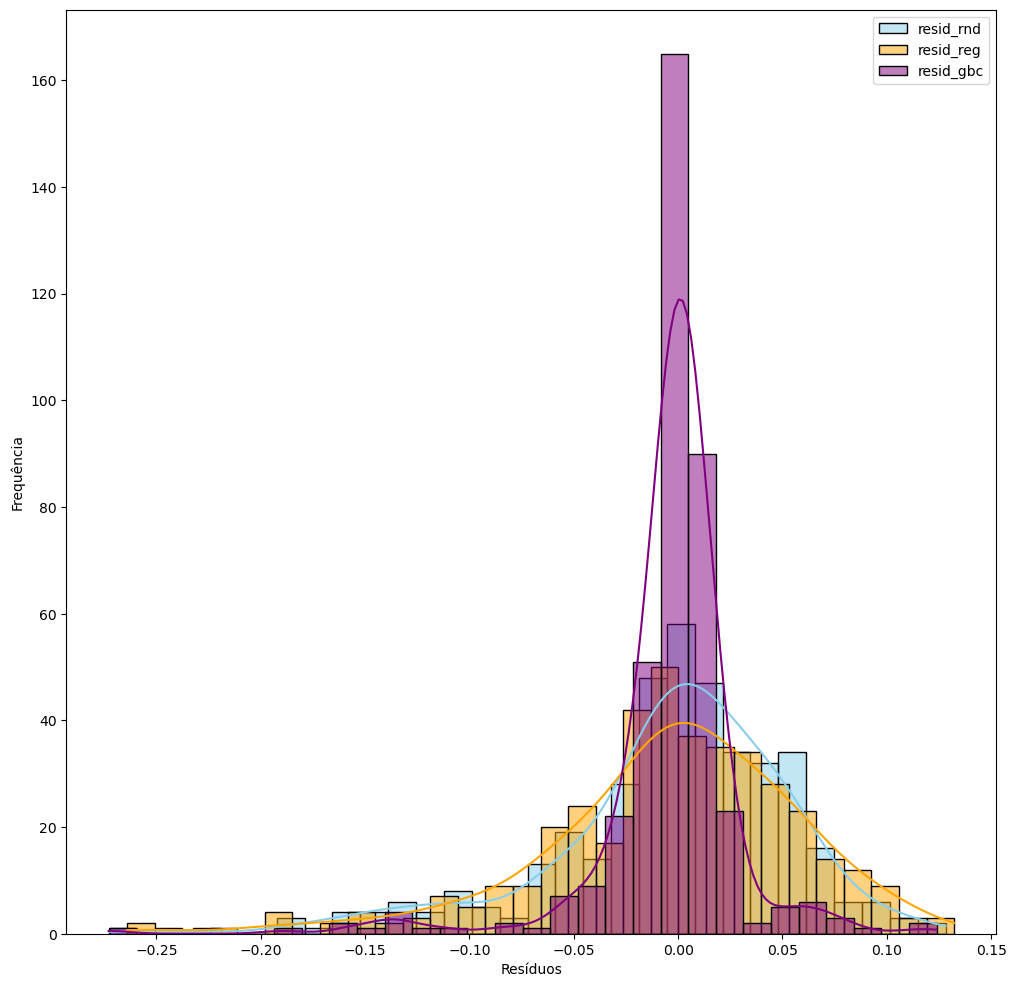

In [178]:
#%% Visualizando a distribuição dos resíduos

plt.figure(figsize=(12, 12))

sns.histplot(df['resid_rnd'], color="skyblue", label='resid_rnd', bins=30, kde=True)
sns.histplot(df['resid_reg'], color="orange", label='resid_reg', bins=30, kde=True)
sns.histplot(df['resid_gbc'], color = "purple", label='resid_gbc', bins=30, kde=True)
plt.legend(loc='upper right')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

### Fazendo o deploy do modelo de forma local

In [184]:
#!pip3 install dill

In [181]:
import dill

"""
usando o pipe lá de cima -> # Grid Search com random forest
# gerado um pipeline com todas as instruções para gerar o modelo final
## primeiro: será feita a padronização dos dados
## segundo: será feito o grid de procura dos melhores parâmetros para o modelo

pipe = make_pipeline(scaler, gs_rand)
"""

# salvar o modelo de utilizando a bibliteca dill
with open('model_pipe.pkl', 'wb') as f:
    dill.dump(pipe, f)

### Fazendo o predict do modelo salvo

In [183]:
# Utilizar o modelo salvo na máquina
    
with open('model_pipe.pkl', 'rb') as f:
    modelo = dill.load(f)
    
#%% Fazendo o predict do modelo salvo
    
predict = pd.DataFrame({'gre_score':[337], 
                        'toefl_score':[118], 
                        'uvinersity_rating':[5], 
                        'sop':[4.5], 
                        'lor':[4.5], 
                        'cgpa':[9.65],
                        'research':[1]})
        
print(modelo.predict(predict))

[0.94423911]


/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
